<a href="https://colab.research.google.com/github/haiderareeb/RandomForestLearning/blob/main/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#requirements
!pip install pandas-profiling numpy matplotlib seaborn --quiet
!pip install opendatasets scikit-learn jovian  --quiet --upgrade
!pip install plotly --quiet --upgrade
import plotly.express as px
import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import os
import jovian as jv
%matplotlib inline

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10,6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 61.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 4.6 MB/s eta 0:00:00


In [5]:
#Data Gathering
od.download('https://www.kaggle.com/jsphyg/weather-dataset-rattle-package')
os.listdir('weather-dataset-rattle-package')
df= pd.read_csv('weather-dataset-rattle-package/weatherAUS.csv')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: areebhaider
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package


100%|██████████| 3.83M/3.83M [00:00<00:00, 73.9MB/s]

In [5]:
# EDA
px.histogram(df,x='RainTomorrow',
             color='RainToday',
             title='Rain Tomorrow vs. Rain Today'
             ).show()

In [9]:
#Data Preprocessing
df.dropna(subset=['RainTomorrow'],inplace=True)

#split dataset
year = pd.to_datetime(df.Date).dt.year

train_df = df[year<2015]
val_df = df[year==2015]
test_df = df[year>2015]

input_cols = list(train_df.columns[1:-1])
target_col = 'RainTomorrow'

#creating inputs & outputs for each dataset
x_train = train_df[input_cols].copy()
y_train = train_df[target_cols].copy()

x_val = val_df[input_cols].copy()
y_val = val_df[target_cols].copy()

x_test = test_df[input_cols].copy()
y_test = test_df[target_cols].copy()

#collect numerical & categorical cols
num_cols = x_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = x_train.select_dtypes('object').columns.tolist()

#Imputing Missing Numeric values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean').fit(x_train[num_cols])
x_train[num_cols] = imputer.transform(x_train[num_cols])
x_val[num_cols] = imputer.transform(x_val[num_cols])
x_test[num_cols] = imputer.transform(x_test[num_cols])

#Scaling Numeric Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(df[num_cols])
x_train[num_cols] = scaler.transform(x_train[num_cols])
x_val[num_cols] = scaler.transform(x_val[num_cols])
x_test[num_cols] = scaler.transform(x_test[num_cols])

#Encoding Categorical cols
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False).fit(df[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
# Encoding categorical columns
encoded_train = pd.DataFrame(encoder.transform(x_train[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols), index=x_train.index)
encoded_val = pd.DataFrame(encoder.transform(x_val[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols), index=x_val.index)
encoded_test = pd.DataFrame(encoder.transform(x_test[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols), index=x_test.index)

# Concatenate numeric and one-hot encoded categorical columns into a single dataframe
x_train = pd.concat([x_train[num_cols], encoded_train], axis=1)
x_val = pd.concat([x_val[num_cols], encoded_val], axis=1)
x_test = pd.concat([x_test[num_cols], encoded_test], axis=1)

# Save processed data to disk
x_train.to_parquet('x_train.parquet')
x_val.to_parquet('x_val.parquet')
x_test.to_parquet('x_test.parquet')
pd.DataFrame(y_train).to_parquet('y_train.parquet')
pd.DataFrame(y_val).to_parquet('y_val.parquet')
pd.DataFrame(y_test).to_parquet('y_test.parquet')

# Load processed data from disk
x_train = pd.read_parquet('x_train.parquet')
x_val = pd.read_parquet('x_val.parquet')
x_test = pd.read_parquet('x_test.parquet')
y_train = pd.read_parquet('y_train.parquet')[target_col]
y_val = pd.read_parquet('y_val.parquet')[target_col]
y_test = pd.read_parquet('y_test.parquet')[target_col]


In [10]:
#Model Training
from sklearn.ensemble import RandomForestClassifier
# n_jobs allows the random forest to use mutiple parallel workers to train decision trees
model = RandomForestClassifier(n_jobs=-1,random_state=42).fit(x_train,y_train)

In [12]:
#testing the model performance
print("Training score: ", model.score(x_train,y_train))
print("Validation score: ", model.score(x_val,y_val))
print("Test score: ", model.score(x_test,y_test))
train_probs = model.predict_proba(x_train)
# print("Training prob: ", train_probs)

Training score:  0.9999595910615429
Validation score:  0.855725146538216
Test score:  0.8443828443828444


In [13]:
#we can access individual decision trees using
model.estimators_[0]

from sklearn.tree import plot_tree
plt.figure(figsize=(80,20))
# Convert class names to strings before passing to plot_tree (class_names need string values to concatenate)
class_names_str = [str(c) for c in model.classes_]
# plot_tree(model.estimators_[0],max_depth=2,feature_names=train_inputs.columns,filled=True,rounded=True,class_names=class_names_str)

len(model.estimators_)

100

<Figure size 8000x2000 with 0 Axes>

<Axes: title={'center': 'Feature Importance'}, xlabel='importance', ylabel='feature'>

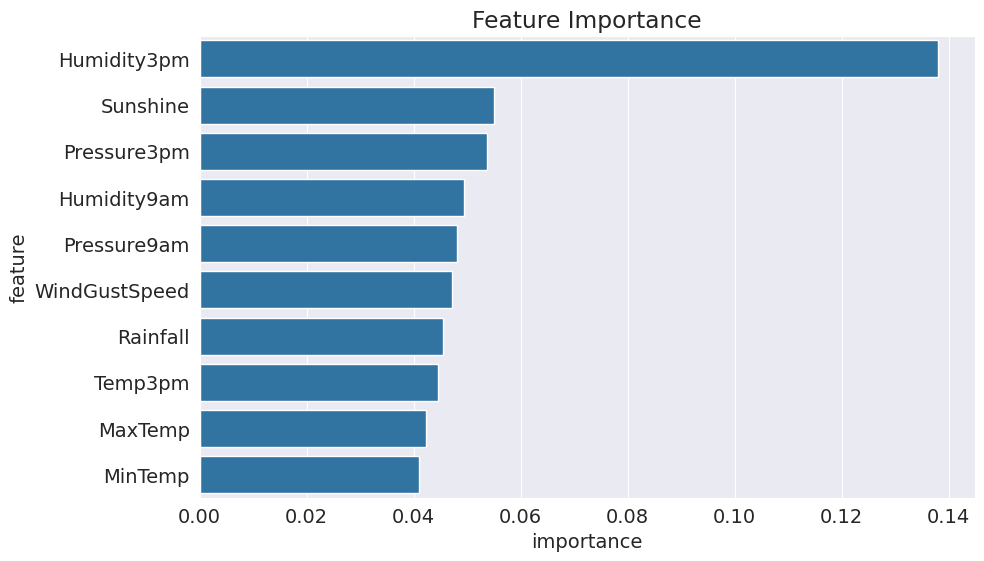

In [14]:
#random forests also assign an "importance" to each feature, by combining the importance values from individual trees.
importance_df = pd.DataFrame({
    'feature': x_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
importance_df.head(10)

plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance',y='feature')

In [15]:
#Hyperparameter tuning with random forests
base_model = model
base_train_acc = base_model.score(x_train, y_train)
base_val_acc = base_model.score(x_val, y_val)
base_accs = base_train_acc, base_val_acc
print(f'Base model train acc: {base_train_acc:.4f}, val acc: {base_val_acc:.4f}')

Base model train acc: 1.0000, val acc: 0.8557


In [16]:
#1) Hyperparamter: n_estimators: This argument controls the number of decision trees in the random forest. The default value is 100.
#  For larger datasets, it helps to have a greater number of estimators. As a general rule, try to have as few estimators as needed.
#10 n_estimators
model1 = RandomForestClassifier(n_estimators=10,n_jobs=-1,random_state=42).fit(x_train,y_train)
print('training score: ',model1.score(x_train,y_train))
print('validation score: ',model1.score(x_val,y_val))

training score:  0.987331797793672
validation score:  0.8434797748244444


In [17]:
#500 n_estimators
model2 = RandomForestClassifier(n_estimators=500,n_jobs=-1,random_state=42).fit(x_train,y_train)
print('training score: ',model2.score(x_train,y_train))
print('validation score: ',model2.score(x_val,y_val))

training score:  0.9999797955307714
validation score:  0.8571179850269862


In [18]:
#2) max_depth and max_leaf_nodes: These arguments are passed directly to each decision tree, and control the maximum depth and max. no leaf nodes of each tree respectively. By default, no maximum depth is specified,
# which is why each tree has a training accuracy of 100%. You can specify a max_depth to reduce overfitting.

def test_params(**params):
    model3 = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(x_train,y_train)
    return model3.score(x_train,y_train), model3.score(x_val,y_val)

print(test_params(max_depth=5))
print(test_params(max_depth=26))
print(test_params(max_leaf_nodes=2**20))

(0.8197559300117186, 0.8239800359816609)
(0.9814623994827656, 0.856363530845569)
(0.9999595910615429, 0.8565376356566653)


In [19]:
#3) max_features: Instead of picking all features (columns) for every split, we can specify that only a fraction of features be chosen randomly to figure out a split.
# Notice that the default value auto causes only sqrt(n) out of total features (n) to be chosen randomly at each split.
# This is the reason each decision tree in the forest is different. While it may seem counterintuitive, choosing all features for every split of every tree will lead to identical trees,
# so the random forest will not generalize well.

print(test_params(max_features='log2'))
print(test_params(max_features=3))

(0.9999494888269285, 0.8559572862863444)
(0.9999393865923142, 0.8511984214497127)


In [20]:
#4) min_samples_split and min_samples_leaf
# min_samples_leaf: Without min_samples_leaf, the tree might create leaf nodes with only a few samples. If a leaf has only 1 or 2 samples, the tree might classify those based on just those few points, which could lead to poor performance on unseen data.
# min_samples_split: Without min_samples_split, the tree might end up with many very small splits, leading to complex rules that perfectly fit the training data but perform poorly on unseen data.
print(test_params(min_samples_split=3, min_samples_leaf=2))
print(test_params(min_samples_split=100, min_samples_leaf=60))

(0.9626419363963309, 0.8571179850269862)
(0.8501333494969087, 0.8454529626835355)


In [21]:
#5) bootstrap, max_samples
# bootstrapping: By default, a random forest doesn't use the entire dataset for training each decision tree. Instead it applies a technique called bootstrapping. For each tree, rows from the dataset are picked one by one randomly,
# with replacement i.e. some rows may not show up at all, while some rows may show up multiple times.
print(test_params(bootstrap=False))

#max_samples: When bootstrapping is enabled, you can also control the number or fraction of rows to be considered for each bootstrap using max_samples. This can further generalize the model.
print(test_params(max_samples=0.9)) #90% of the rows will be selected from the dataset

(0.9999797955307714, 0.8568858452788579)
(0.9997777508384855, 0.8567697754047937)


In [22]:
#6) class_weight
model.classes_
#class imbalance: class imbalance occurs when the classes in the target variable are not evenly distributed. For example, if you have a dataset with 90% of one class and only 10% of another class,
# a model trained on this data might be biased toward predicting the majority class.

# below code: the model automatically adjusts the weight of each class inversely proportional to its frequency in the dataset.
test_params(class_weight='balanced')

(0.9999595910615429, 0.8559572862863444)

In [42]:
#final model
model = RandomForestClassifier(n_jobs=-1,
                               random_state=42,
                               min_samples_split=3,
                               min_samples_leaf = 2,
                               n_estimators = 200,
                               class_weight='balanced').fit(x_train,y_train)

In [43]:
model.score(x_train,y_train), model.score(x_val,y_val),model.score(x_test,y_test)


(0.9835939709863822, 0.8565956705936975, 0.8450373450373451)